# FSM Notebook

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import seaborn as sns

# NBA 1980 -2008

## Connect to SQLite3

In [2]:
import sqlite3
conn = sqlite3.connect('AI_SCOUT.db')
pd.read_sql('SELECT * FROM RAPTOR', conn)

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,...,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,...,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,...,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,...,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,...,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,...,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20054,weissbo01,Bob Weiss,1977,34,PG,WSB,1.0,WAS,62,768,...,3.1,0.5,99.5,11.5,97.9,46.6,NaN,78.4,0.0,27.8
20055,riordmi01,Mike Riordan,1977,31,SF,WSB,1.0,WAS,49,289,...,0.5,0.4,81.1,15.4,103.3,36.2,NaN,73.3,0.0,16.0
20056,weathni01,Nick Weatherspoon,1977,26,SF,WSB,1.0,WAS,11,152,...,0.9,1.7,78.3,21.1,100.9,35.5,NaN,62.5,0.0,10.5
20057,pacejo01,Joe Pace,1977,23,C,WSB,1.0,WAS,30,119,...,0.8,7.3,88.2,27.3,94.3,43.6,NaN,55.2,0.0,52.7


In [3]:
pd.read_sql('SELECT * FROM RAPTOR', conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20059 entries, 0 to 20058
Data columns (total 40 columns):
player_id      20059 non-null object
name_common    20059 non-null object
year_id        20059 non-null int64
age            20059 non-null int64
pos            20059 non-null object
team_id        20059 non-null object
tmRtg          20059 non-null float64
franch_id      20059 non-null object
G              20059 non-null int64
Min            20059 non-null int64
MP%            20059 non-null float64
MPG            20059 non-null float64
P/36           20054 non-null float64
TS%            19964 non-null float64
A/36           20054 non-null float64
R/36           20054 non-null float64
SB/36          20054 non-null float64
TO/36          20054 non-null float64
Raptor O       20059 non-null float64
Raptor D       20059 non-null float64
Raptor+/-      20059 non-null float64
Raptor WAR     20059 non-null float64
PIE%           20054 non-null float64
AWS%           20054 non-null 

In [180]:
pd.read_sql(
    """
    SELECT * FROM RAPTOR
    WHERE name_common = 'Lebron James'
    """, conn)

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr


## Create Training Dataset (1980 to 2000)

In [4]:
# Training Set Data will be data 1980 to 2000
# Test Set will be data 2000 to 2020 Players
# Target Position ['PG', 'SF', 'SG', 'PF', 'C', 'G-F', 'F', 'G']

df_oldNBA = pd.read_sql(
    """
    SELECT * FROM RAPTOR
    WHERE year_id BETWEEN 1990 AND 2000
    AND G > 35;
    """, conn)

In [7]:
pd.set_option('display.max_columns', 100)
df_oldNBA.tail()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
4987,turpime01,Melvin Turpin,1990,29,C,WSB,-2.2,WAS,59,818,20.6,13.9,12.2,57.4,1.2,9.8,2.7,2.0,-2.0,0.3,-1.8,0.4,7.4,8.8,14.3,4.3,15.8,11.5,17.7,14.6,0.9,3.3,112.2,14.8,107.9,53.1,0.0,78.9,1.0,34.0
4988,hammoto01,Tom Hammonds,1990,22,PF,WSB,-2.2,WAS,61,805,20.3,13.2,14.4,47.5,2.3,7.6,1.1,2.1,-3.2,-1.9,-5.1,-1.0,6.1,4.7,19.5,8.5,12.0,8.1,14.5,11.3,0.7,1.0,99.3,19.3,111.2,43.9,0.0,64.3,0.3,33.2
4989,willijo02,John Williams,1990,23,SF,WSB,-2.2,WAS,18,632,15.9,35.1,18.7,52.6,4.8,7.8,1.7,2.5,1.2,0.4,1.7,1.4,13.6,12.7,22.9,18.9,12.1,4.6,18.8,11.6,1.6,0.8,107.4,22.7,108.2,50.0,11.1,77.4,6.6,30.7
4990,rothdo01,Doug Roth,1990,22,C,WSB,-2.2,WAS,42,412,10.4,9.8,7.1,43.9,1.8,10.5,1.8,1.4,-3.9,0.0,-3.9,-0.2,4.7,5.2,10.7,5.9,14.8,11.4,20.1,15.7,0.9,1.8,100.0,11.7,108.1,43.5,0.0,50.0,1.2,16.3
4991,hortoed01,Ed Horton,1990,22,PF,WSB,-2.2,WAS,45,374,9.4,8.3,19.6,52.5,1.8,10.5,1.4,3.8,-1.3,-2.1,-3.4,-0.1,7.2,7.5,25.3,7.3,16.9,16.9,14.2,15.6,1.2,0.8,101.1,25.8,110.3,50.6,0.0,60.9,2.5,42.6


In [8]:
df_oldNBA.describe()

,year_id,age,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
count,4992.000000,4992.000000,4992.00000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4970.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.00000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4958.000000,4033.000000,4778.000000,4963.000000,4963.000000
mean,1995.180889,27.234976,-0.23768,49.250000,1173.816106,30.749479,20.067448,14.458514,50.259940,3.303906,6.766727,2.116887,2.537400,-1.592408,-0.447656,-2.041426,1.64355,7.780369,7.272216,19.249559,13.409375,15.185337,6.655769,13.425561,10.036959,1.739303,1.445353,101.456130,19.246374,106.798758,45.512666,24.707736,71.816450,13.514185,33.863268
std,3.140268,3.940638,5.35161,27.327727,959.936447,24.690666,10.795172,5.556451,9.779262,2.506576,3.655953,1.383702,1.596829,4.154268,2.062242,5.118834,3.12517,5.385447,7.662980,6.110061,10.291519,7.032511,5.486185,7.360402,5.397044,1.145989,2.149260,18.524111,5.881230,5.010153,10.435388,18.371247,14.452579,16.532818,23.575109
min,1990.000000,18.000000,-15.20000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-82.200000,-20.900000,-103.100000,-5.40000,-68.600000,-150.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.300000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1992.000000,24.000000,-4.22500,25.000000,282.000000,7.575000,10.900000,11.200000,47.200000,1.500000,4.000000,1.400000,1.800000,-3.300000,-1.500000,-4.000000,-0.20000,5.600000,4.700000,15.600000,6.200000,11.500000,2.900000,8.400000,5.900000,1.100000,0.300000,96.300000,15.900000,103.900000,42.300000,7.700000,65.500000,0.500000,21.700000
50%,1995.000000,27.000000,0.60000,52.000000,986.500000,25.950000,19.200000,14.300000,51.550000,2.600000,6.200000,2.000000,2.400000,-1.200000,-0.500000,-1.700000,0.30000,8.100000,8.000000,18.900000,10.700000,14.300000,5.900000,12.400000,9.300000,1.600000,0.900000,103.900000,18.900000,107.100000,46.600000,28.600000,73.900000,5.400000,30.800000
75%,1998.000000,30.000000,3.60000,76.000000,1931.000000,51.300000,29.400000,17.500000,55.100000,4.400000,9.200000,2.600000,3.000000,0.600000,0.600000,0.600000,2.50000,10.500000,11.000000,22.400000,18.300000,17.800000,9.400000,17.900000,13.600000,2.200000,1.900000,110.200000,22.100000,110.125000,50.100000,36.200000,80.800000,23.550000,41.000000
max,2000.000000,43.000000,13.40000,82.000000,3533.000000,89.300000,44.500000,119.800000,113.600000,26.500000,79.600000,40.800000,39.900000,38.200000,24.800000,37.800000,22.70000,65.200000,70.400000,163.000000,182.300000,100.000000,118.400000,231.800000,114.900000,17.500000,77.800000,250.000000,187.800000,121.300000,100.000000,100.000000,100.000000,100.000000,400.000000


In [14]:
# Dropping player_id, name_common, year_id, team_id, franc_id 
df_oldNBA.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id'], axis=1, inplace=True)
df_oldNBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 35 columns):
age           4992 non-null int64
pos           4992 non-null object
tmRtg         4992 non-null float64
G             4992 non-null int64
Min           4992 non-null int64
MP%           4992 non-null float64
MPG           4992 non-null float64
P/36          4992 non-null float64
TS%           4970 non-null float64
A/36          4992 non-null float64
R/36          4992 non-null float64
SB/36         4992 non-null float64
TO/36         4992 non-null float64
Raptor O      4992 non-null float64
Raptor D      4992 non-null float64
Raptor+/-     4992 non-null float64
Raptor WAR    4992 non-null float64
PIE%          4992 non-null float64
AWS%          4992 non-null float64
USG%          4992 non-null float64
AST%          4992 non-null float64
TOV%          4992 non-null float64
ORB%          4992 non-null float64
DRB%          4992 non-null float64
TRB%          4992 non-null float64


#### Clean Missing Data

In [15]:
df_oldNBA.shape

(4992, 35)

In [11]:
df_oldNBA.isna().sum()

player_id        0
name_common      0
year_id          0
age              0
pos              0
team_id          0
tmRtg            0
franch_id        0
G                0
Min              0
MP%              0
MPG              0
P/36             0
TS%             22
A/36             0
R/36             0
SB/36            0
TO/36            0
Raptor O         0
Raptor D         0
Raptor+/-        0
Raptor WAR       0
PIE%             0
AWS%             0
USG%             0
AST%             0
TOV%             0
ORB%             0
DRB%             0
TRB%             0
STL%             0
BLK%             0
ORtg             0
%Pos             0
DRtg             0
2P%             34
3P%            959
FT%            214
3PAr            29
FTAr            29
dtype: int64

In [16]:
df_oldNBA[df_oldNBA.isna().any(axis=1)]

,age,pos,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,33,C,-5.8,82,2984,75.2,36.4,12.4,62.1,1.4,15.2,3.9,2.3,0.1,1.2,1.3,6.2,14.9,17.3,13.8,5.4,18.7,11.2,31.3,21.2,0.5,5.9,116.1,14.9,100.7,56.2,NaN,70.8,0.0,73.5
24,23,PF,-0.8,55,856,21.7,15.6,18.6,60.2,1.3,16.3,1.1,3.0,2.0,-1.4,0.7,1.5,12.7,14.3,21.0,5.6,16.1,17.8,31.7,24.4,1.2,0.4,116.9,22.1,103.2,52.8,NaN,73.5,0.0,71.3
26,32,C,-0.8,30,269,6.8,9.0,7.5,50.7,1.8,9.5,2.5,1.8,-2.8,0.1,-2.7,0.0,2.6,4.0,10.5,6.9,19.9,11.7,17.0,14.2,1.9,2.2,106.5,11.9,104.0,44.2,NaN,71.4,0.0,48.8
27,23,PG,-0.8,3,41,1.0,13.7,3.7,23.1,4.6,2.8,0.0,2.8,-8.0,-5.1,-13.1,-0.2,-3.5,-8.1,12.3,16.3,25.8,2.6,5.9,4.2,0.0,0.0,59.8,13.5,112.8,16.7,NaN,33.3,0.0,100.0
40,25,C,2.8,41,399,10.1,9.7,12.9,46.1,0.5,10.6,1.6,2.6,-6.0,-0.4,-6.4,-0.7,6.0,4.5,19.4,2.0,15.7,10.4,20.4,15.5,1.2,1.4,89.4,19.2,101.4,41.8,NaN,60.4,0.0,43.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4967,33,C,5.0,82,2281,57.5,27.8,6.5,56.1,0.6,9.9,3.8,1.2,-3.4,2.9,-0.5,2.6,7.3,9.1,8.2,2.2,17.6,9.4,20.8,15.4,0.7,5.5,111.2,8.7,102.5,52.7,NaN,66.9,0.0,39.3
4973,23,C,5.0,77,764,19.3,9.9,16.2,61.3,0.9,9.4,1.9,3.1,-3.4,0.0,-3.4,-0.2,7.4,5.5,19.0,3.7,18.9,7.9,20.8,14.7,1.0,1.9,106.2,18.3,104.3,56.3,NaN,74.3,0.0,49.1
4976,24,PF,5.0,16,56,1.4,3.5,10.7,27.7,2.7,10.0,0.0,4.0,-9.9,-4.5,-14.4,-0.3,-4.5,-9.8,27.2,10.3,17.2,22.4,9.8,15.7,0.0,0.0,70.4,27.8,111.1,28.6,NaN,0.0,0.0,7.1
4978,26,PG,5.0,1,6,0.2,6.0,12.5,56.8,6.2,0.0,0.0,18.7,-22.7,-11.6,-34.4,-0.1,-23.6,-43.9,34.6,19.8,63.0,0.0,0.0,0.0,0.0,0.0,49.6,39.6,113.4,NaN,NaN,50.0,NaN,NaN


In [18]:
df_oldNBA.dropna(inplace=True)

In [19]:
df_oldNBA.shape

(3959, 35)

## Train, Test Split

In [20]:
from sklearn.model_selection import train_test_split

In [91]:
# Define X and y
X = df_oldNBA.drop(columns=['pos'], axis = 1)
y = df_oldNBA['pos']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [23]:
# Check value counts
print(y_train.value_counts(), '\n\n', y_test.value_counts())

SG    690
PG    679
SF    607
PF    594
C     399
Name: pos, dtype: int64 

 PG    233
SF    213
PF    205
SG    199
C     140
Name: pos, dtype: int64


## Fit Model

In [24]:
from sklearn.linear_model import LogisticRegression

In [25]:
# Instantiate the model
lr = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
lr.fit(X_train, y_train)

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Predict

In [111]:
# Generate predictions
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)
y_hat_test_proba = lr.predict_proba(X_test)


In [113]:
y_hat_test= pd.Series(y_hat_test)

In [115]:
y_hat_test.value_counts()

PG    258
SG    216
PF    199
SF    173
C     144
dtype: int64

In [118]:
y_test.value_counts()

PG    233
SF    213
PF    205
SG    199
C     140
Name: pos, dtype: int64

## Evaluate

In [31]:
from sklearn.metrics import confusion_matrix

In [116]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print(cnf_matrix)

[[124  15   0   1   0]
 [ 20 146   3  27   9]
 [  0   2 217   2  12]
 [  0  30   5 116  62]
 [  0   6  33  27 133]]


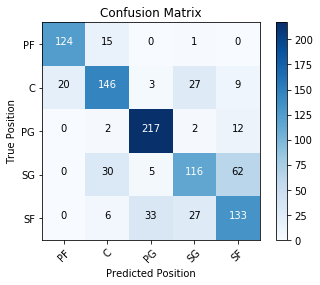

In [136]:
show_cm(cnf_matrix)

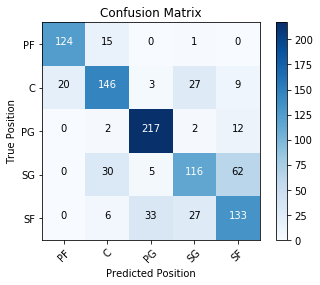

In [117]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True Position')
plt.xlabel('Predicted Position')

class_names = set(y) 
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cnf_matrix.max() / 2.  
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

plt.colorbar()
plt.show()

In [121]:
# C
146/(20+146+3+27+9)

0.7121951219512195

In [123]:
# PG 
217/(2+217+2+12)

0.9313304721030042

### Savefig

In [ ]:
plt.savefig('../../reports/figures/fsm_cm.png', transparent=True)

# Modern NBA (2008-Present)

In [166]:
df_newNBA = pd.read_sql(
    """ 
    SELECT * FROM RAPTOR
    WHERE year_id BETWEEN 2008 AND 2020
    AND G >= 35
    """, conn)
df_newNBA.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8


In [40]:
df_newNBA[df_newNBA.isna().any(axis=1)]

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
27,jordade01,DeAndre Jordan,2020,31,C,BRK,-0.6,NJN,56,1234,39.7,22.0,13.4,68.2,3.0,16.2,2.0,2.1,-1.5,1.6,0.1,1.8,16.4,17.1,14.1,12.8,17.8,12.1,34.2,23.4,0.7,3.5,128.5,15.4,103.6,66.6,NaN,68.0,0.0,42.5
41,gaffoda01,Daniel Gafford,2020,21,C,CHI,-3.1,CHI,43,609,19.4,14.2,13.1,68.6,1.2,6.3,4.1,1.7,-2.6,0.7,-1.9,0.3,7.0,9.8,13.3,5.2,15.3,9.0,10.3,9.6,1.0,8.7,124.3,13.4,108.6,70.1,NaN,53.3,0.0,44.8
51,biyombi01,Bismack Biyombo,2020,27,C,CHO,-7.0,CHA,53,1029,32.7,19.4,14.3,57.0,1.8,11.2,2.2,1.8,-2.4,-0.9,-3.2,-0.3,9.4,10.6,16.8,7.8,12.2,12.3,20.7,16.3,0.5,4.4,116.2,17.5,112.0,54.3,NaN,60.3,0.0,54.3
104,caulewi01,Willie Cauley-Stein,2020,26,C,GSW,-8.6,GSW,41,940,29.9,22.9,12.3,57.3,2.3,9.7,3.6,1.3,-4.1,5.0,0.8,1.7,10.4,11.9,14.4,9.9,11.0,7.9,22.0,14.7,2.3,4.8,114.5,14.6,108.6,56.0,NaN,61.4,0.0,22.2
112,capelca01,Clint Capela,2020,25,C,HOU,3.6,HOU,39,1279,41.4,32.8,14.8,62.6,1.3,14.6,2.9,1.7,-1.1,4.5,3.4,4.0,14.3,15.8,16.0,5.7,12.7,13.7,30.5,22.0,1.2,4.8,124.3,16.8,105.3,62.9,NaN,52.9,0.0,26.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,curryed01,Eddy Curry,2008,25,C,NYK,-7.1,NYK,59,1530,38.5,25.9,20.1,57.8,0.8,7.1,1.1,3.2,-3.3,-4.0,-7.4,-3.6,8.3,7.1,23.5,3.8,15.7,8.0,12.6,10.2,0.5,1.5,104.9,23.1,114.1,54.6,NaN,62.3,0.0,55.1
4310,foylead01,Adonal Foyle,2008,32,C,ORL,5.8,ORL,82,774,19.6,9.4,7.8,46.4,0.9,10.4,3.0,1.6,-5.4,1.9,-3.5,-0.3,6.0,6.9,11.8,3.4,16.0,11.0,19.6,15.5,1.1,4.2,99.1,12.7,102.4,45.8,NaN,47.1,0.0,22.2
4360,elsonfr01,Francisco Elson,2008,31,C,SAS,5.4,SAS,41,534,13.5,13.0,10.9,45.4,1.2,10.3,1.7,2.3,-6.2,0.9,-5.3,-0.7,6.6,4.1,16.9,4.8,15.9,7.4,22.2,14.9,0.9,2.0,89.2,17.0,100.5,41.9,NaN,83.3,0.0,16.2
4370,thomaku01,Kurt Thomas,2008,35,C,SEA,-9.0,OKC,42,1060,26.7,25.2,11.2,53.6,1.9,13.0,2.7,1.0,-1.6,2.6,1.0,2.0,11.7,13.4,13.2,7.6,8.7,9.7,28.2,19.0,1.6,2.9,115.0,13.6,103.8,51.3,NaN,69.6,0.0,20.7


In [87]:
df_newNBA.drop(['player_id', 'name_common', 'year_id', 'team_id', 'franch_id'], axis=1, inplace=True)
df_newNBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4408 entries, 0 to 4407
Data columns (total 35 columns):
age           4408 non-null int64
pos           4408 non-null object
tmRtg         4408 non-null float64
G             4408 non-null int64
Min           4408 non-null int64
MP%           4408 non-null float64
MPG           4408 non-null float64
P/36          4408 non-null float64
TS%           4408 non-null float64
A/36          4408 non-null float64
R/36          4408 non-null float64
SB/36         4408 non-null float64
TO/36         4408 non-null float64
Raptor O      4408 non-null float64
Raptor D      4408 non-null float64
Raptor+/-     4408 non-null float64
Raptor WAR    4408 non-null float64
PIE%          4408 non-null float64
AWS%          4408 non-null float64
USG%          4408 non-null float64
AST%          4408 non-null float64
TOV%          4408 non-null float64
ORB%          4408 non-null float64
DRB%          4408 non-null float64
TRB%          4408 non-null float64


In [167]:
df_newNBA['3P%'].fillna(0, inplace = True)

In [168]:
df_newNBA[df_newNBA.isna().any(axis=1)]

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
1272,rudezda01,Damjan Rudez,2017,30,SF,ORL,-6.7,ORL,45,314,7.9,7.0,9.7,46.6,2.4,3.0,1.5,1.1,-3.6,-3.7,-7.4,-0.7,3.4,3.8,13.6,9.2,9.3,1.7,7.1,4.3,1.9,0.3,95.0,13.3,112.7,45.8,31.3,NaN,72.7,0.0
1460,millemi01,Mike Miller,2016,35,SF,DEN,-3.2,DEN,47,373,9.4,7.9,6.4,50.8,4.0,5.3,1.7,1.7,-1.7,-0.2,-1.9,0.2,4.3,4.1,9.3,14.9,21.5,1.8,14.2,7.9,1.7,0.9,100.2,10.0,109.3,30.0,36.5,NaN,83.9,0.0


In [169]:
millemiFT = df_newNBA.loc[df_newNBA['name_common'] == 'Mike Miller', 'FT%'].mean()
millemiFT

71.30000000000001

In [170]:
df_newNBA.loc[df_newNBA['name_common'] == 'Damjan Rudez']

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
1272,rudezda01,Damjan Rudez,2017,30,SF,ORL,-6.7,ORL,45,314,7.9,7.0,9.7,46.6,2.4,3.0,1.5,1.1,-3.6,-3.7,-7.4,-0.7,3.4,3.8,13.6,9.2,9.3,1.7,7.1,4.3,1.9,0.3,95.0,13.3,112.7,45.8,31.3,NaN,72.7,0.0
1861,rudezda01,Damjan Rudez,2015,28,SF,IND,0.3,IND,68,1047,26.4,15.4,11.9,59.1,2.0,1.7,0.8,1.7,-1.4,-2.8,-4.2,-0.8,4.7,5.3,13.8,7.9,14.7,0.9,4.1,2.5,0.8,0.4,104.7,13.2,108.6,53.8,40.6,69.6,64.6,8.7


In [171]:
rudezdaFT = 69.6

In [172]:
df_newNBA.loc[df_newNBA['name_common'] == 'Mike Miller', 'FT%'].fillna(value=millemiFT, inplace=True)

In [176]:
df_newNBA[df_newNBA.isna().any(axis=1)]

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr


In [174]:
df_newNBA.at[1460,'FT%'] = millemiFT

In [175]:
df_newNBA.at[1272,'FT%'] = rudezdaFT

In [177]:
df_newNBA.shape

(4408, 40)

In [178]:
df_newNBA.to_sql('MODERN_NBA', conn, if_exists='replace', index=False)

mod_nba_data = "../../data/mod_nba_data.csv"

df_newNBA.to_csv(mod_nba_data)

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/pandas/core/generic.py:2712: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [92]:
# Define X and y
y2 = df_newNBA['pos']
X2 = df_newNBA.drop(columns = ['pos'], axis = 1)

In [93]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 23)

In [105]:
type(y2_train)

pandas.core.series.Series

In [95]:
print(y2_train.value_counts(), '\n\n', y2_test.value_counts())

SG    750
PF    652
PG    648
C     643
SF    613
Name: pos, dtype: int64 

 PF    238
SG    222
C     215
SF    214
PG    213
Name: pos, dtype: int64


In [155]:
def show_cm(cnf_matrix):
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True Position')
    plt.xlabel('Predicted Position')

    class_names = set(y) 
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cnf_matrix.max() / 2.  
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')

    plt.colorbar()
    plt.savefig('../../reports/figures/fsm_cv.png', transparent=True)
    plt.show()

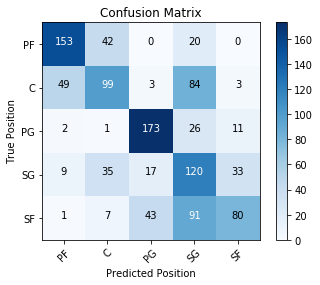

In [134]:
old_y2_hat_test = lr.predict(X2_test)
old_y2_hat_test_proba = lr.predict(X2_test)

old_cnf_matrix2 = confusion_matrix(y2_test, old_y2_hat_test)
show_cm(old_cnf_matrix2)

In [ ]:
plt.savefig('../../reports/figures/fsm_cm.png', transparent=True)

In [120]:
# C
99/(49+99+3+84+3)

0.41596638655462187

In [122]:
# PG
173/(2+1+173+26+11)

0.812206572769953

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


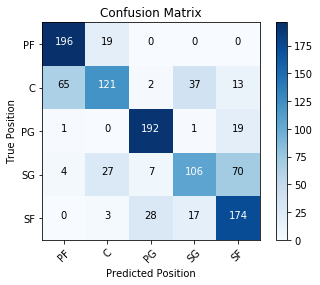

In [132]:
# Define X and y

# Train Test Split

# Instantiate and Fit Model
lr2 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
lr2.fit(X2_train, y2_train)

# Predict
y2_hat_train = lr2.predict(X2_train)
y2_hat_test = lr2.predict(X2_test)
y2_hat_test_proba = lr2.predict_proba(X2_test)

# Evaluate
cnf_matrix2 = confusion_matrix(y2_test, y2_hat_test)
show_cm(cnf_matrix2)

In [130]:
plt.savefig('../../reports/figures/mod_nba_lr.png', transparent=True)

<Figure size 432x288 with 0 Axes>

In [129]:
from sklearn.model_selection import GridSearchCV

solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params = dict(solver=solver_list)
log_reg = LogisticRegression(C=1e12, random_state=23)
clf = GridSearchCV(log_reg, params, cv=5)
clf.fit(X2_train, y2_train)
scores = clf.cv_results_['mean_test_score']

for score, solver in zip(scores, solver_list):
    print(f"  {solver} {score:.3f}" )

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warnin

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_mod

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/ai-scout/lib/pytho

  liblinear 0.685
  newton-cg 0.683
  lbfgs 0.645
  sag 0.574
  saga 0.551


# Tune FSM

In [137]:
from sklearn.preprocessing import StandardScaler

In [139]:
def LRM_ss_scale(X_train, X_test): 
        """
        Feature scaling using sklearn StandardScaler
        note: StandardScaler cannot guarantee balanced feature scales in the presence of outliers.
        Uses scikit-learn: https://scikit-learn.org/stable/index.html
        ...

        Parameters
        ----------
        pandas DataFrame or Series
            Train and Test feature datasets

        Returns
        -------
        pandas DataFrame or Series
            Scaled train and test features

        """
        ss = StandardScaler()

        X_train_scaled = ss.fit_transform(X_train)
        X_test_scaled = ss.transform(X_test)
        return X_train_scaled, X_test_scaled

In [140]:
X_train_scaled, X_test_scaled = LRM_ss_scale(X_train, X_test)

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


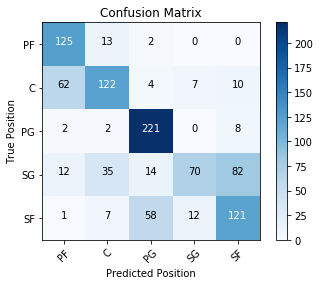

In [142]:
# Instantiate and Fit Model
lr_ss = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
lr_ss.fit(X_train_scaled, y_train)

# Predict
y_ss_hat_train = lr_ss.predict(X_train_scaled)
y_ss_hat_test = lr_ss.predict(X_test_scaled)
y_ss_hat_test_proba = lr_ss.predict_proba(X_test_scaled)

# Evaluate
cnf_matrix_ss = confusion_matrix(y_test, y_ss_hat_test)
show_cm(cnf_matrix_ss)

In [145]:
score = lr.score(X_test, y_test)
print(score)

0.7434343434343434


In [144]:
score = lr_ss.score(X_test_scaled, y_test)
print(score)

0.6656565656565656


In [146]:
# fsm modern data
score = lr.score(X2_test, y2_test)
print(score)

0.5671506352087115


In [147]:
# fsm_ss modern data
score = lr_ss.score(X2_test, y2_test)
print(score)

0.2014519056261343


/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


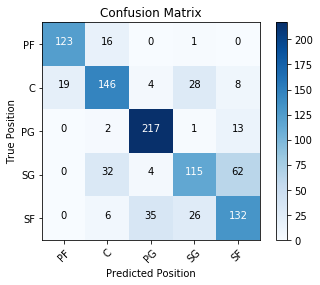

In [152]:
# Instantiate and Fit Model
lr_int = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear')
lr_int.fit(X_train, y_train)

# Predict
y_int_hat_train = lr_int.predict(X_train)
y_int_hat_test = lr_int.predict(X_test)
y_int_hat_test_proba = lr_int.predict_proba(X_test)

# Evaluate
cnf_matrix_int = confusion_matrix(y_test, y_int_hat_test)
show_cm(cnf_matrix_int)

In [153]:
score = lr_int.score(X_test, y_test)
print(score)

0.7404040404040404


In [154]:
from sklearn.linear_model import LogisticRegressionCV

/opt/anaconda3/envs/ai-scout/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


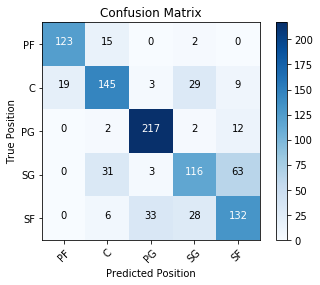

CPU times: user 1min 23s, sys: 470 ms, total: 1min 24s
Wall time: 1min 24s


In [179]:
%%time
lr_cv = LogisticRegressionCV(cv=10, Cs=20, fit_intercept=False, solver='liblinear').fit(X_train, y_train)

# Predict
y_cv_hat_train = lr_cv.predict(X_train)
y_cv_hat_test = lr_cv.predict(X_test)
y_cv_hat_test_proba = lr_cv.predict_proba(X_test)

# Evaluate
cnf_matrix_cv = confusion_matrix(y_test, y_cv_hat_test)
show_cm(cnf_matrix_cv)

In [164]:
score = lr_cv.score(X_test, y_test)
print(score)

0.7414141414141414


Notes for tuning
- minimum 35 games
- dimensionality reduction
- regularization

# Shap Explainer

#### Explain the linear model

In [220]:
import shap

explainer = shap.LinearExplainer(lr, X_train, feature_dependence='independent')
shap_values = explainer.shap_values(X_test)
# X_test_array = X_test.toarray()

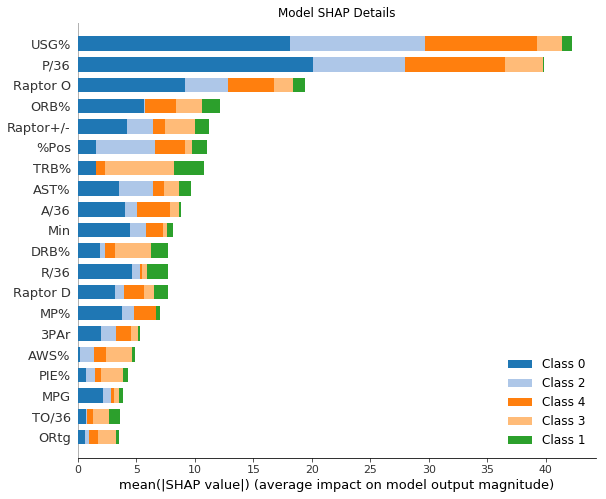

In [240]:
plt.style.use('seaborn-deep')
shap.summary_plot(shap_values, X_test, plot_type='bar', plot_size=(12,8), color=plt.get_cmap("tab20"), show=False)
plt.subplots_adjust(left=0.3)
plt.title('Model SHAP Details')
plt.show()

In [243]:
explainer2 = shap.LinearExplainer(lr, X2_train, feature_dependence='independent')
shap_values2 = explainer2.shap_values(X2_test)
# X_test_array = X_test.toarray()

In [247]:
ind = 0
# shap.force_plot(
#     explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
#     feature_names=vectorizer.get_feature_names()
# )
shap_values[ind,:]

TypeError: list indices must be integers or slices, not tuple

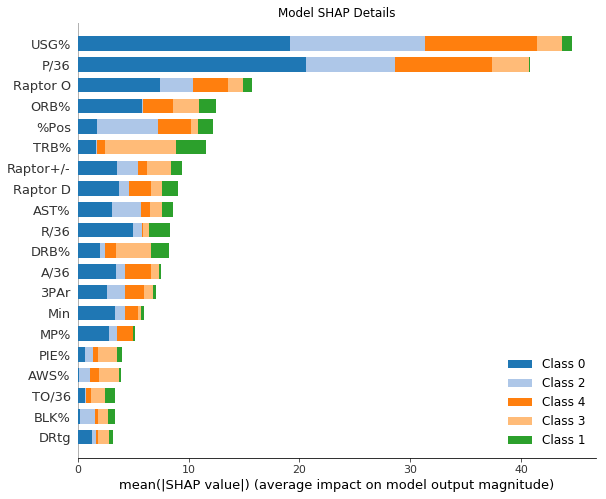

In [241]:
plt.style.use('seaborn-deep')
shap.summary_plot(shap_values2, X2_test, plot_type='bar', plot_size=(12,8), color=plt.get_cmap("tab20"), show=False)
plt.subplots_adjust(left=0.3)
plt.title('Model SHAP Details')
plt.show()

In [ ]:
conn.close()